In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, cm
from skimage.draw import polygon2mask
from scipy import ndimage
from PIL import Image
from src.preprocessing import process_image, process_video, preprocess
from skimage.color import label2rgb
from skimage.morphology import label
from IPython.display import display, clear_output
from skimage.measure import regionprops

In [2]:
label_video = process_video('images/cheese_gel.avi', threshold=0.3, skip_size=20)

In [5]:
a = np.array([3,4,3])
b = np.array([2,4,5])

print(a == b)

[False  True False]


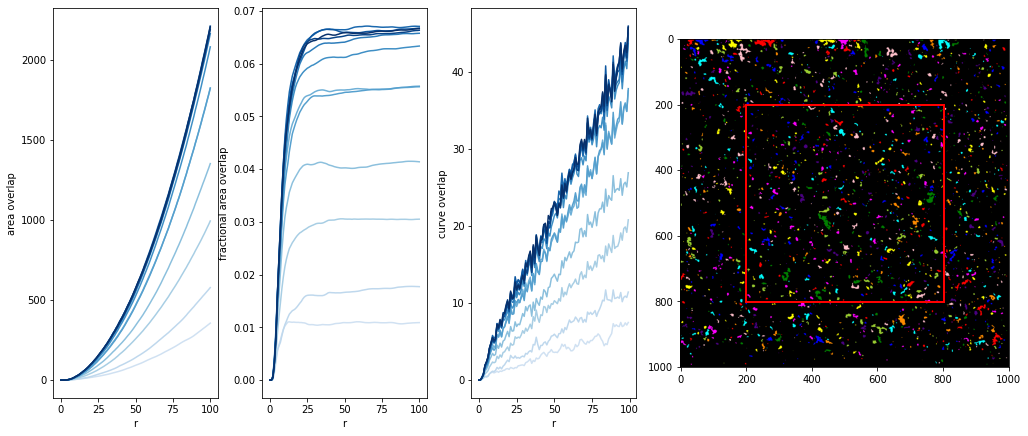

In [4]:
fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()

colors = cm.Blues(np.linspace(0.2, 1, len(label_video)))

    
for p, label_image in enumerate(label_video):
    L = 200 # Maximum distances to consider
    M = label_image.shape[0] - L
    maxR = 100

    label_image_bounded = np.zeros(label_image.shape, dtype=int)
    cluster_num = 1
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        if (minr > L+1) and (minc > L+1) and (maxr < M-1) and (maxc < M-1):
            pixel_coordinates = region.coords
            label_image_bounded[pixel_coordinates[:,0],  pixel_coordinates[:,1]] =  cluster_num
            cluster_num += 1

    bx = (L, M, M, L, L)
    by = (L, L, M, M, L)
    ax[3].plot(bx, by, '-r')
    ax[3].imshow(label2rgb(label_image, bg_label=0))
    curr_image = label_image_bounded

    F = np.zeros(maxR+1)
    G = np.zeros(maxR+1)
    for cluster in range(1, curr_image.max()+1):
        ref_cluster = curr_image == cluster
        rem_clusters = np.logical_and(label_image,np.invert(ref_cluster))
        
        D = ndimage.distance_transform_edt(ref_cluster==0)
        f = np.zeros(maxR+1)
        g = np.zeros(maxR+1)
        for i in range(0,maxR+1):
            K = D <= i
            f[i] = np.count_nonzero(np.logical_and(K,rem_clusters))
            g[i] = np.count_nonzero(K)
        
        F += f
        G += g 

    F = F / curr_image.max()
    G = G / curr_image.max()

    ax[0].plot(F, color=colors[p])
    ax[0].set_xlabel('r')
    ax[0].set_ylabel('area overlap')

    ax[1].plot(F/G, color=colors[p])
    ax[1].set_xlabel('r')
    ax[1].set_ylabel('fractional area overlap')

    ax[2].plot(F[1:]-F[:-1], color=colors[p])
    ax[2].set_xlabel('r')
    ax[2].set_ylabel('curve overlap')

    # Saves to folder called 'frames'
    filename = 'frames/subplot_{:03d}.png'.format(p)
    fig.savefig(filename)
    display(fig)
    clear_output(wait = True)
plt.show()